In [9]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import torch
import random
from torch.utils.data import Dataset, DataLoader
from datasets_dataloader_pytorch import CustomDataset, load_data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score

from CAMELOT2 import CamelotModel, class_weight
from model_utils import MyLRScheduler, calc_l1_l2_loss
from utils import calc_pred_loss, calc_dist_loss, calc_clus_loss, torch_log

SEED = 1111
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = CustomDataset(time_range=(0, 10))

np.unique(np.argmax(dataset.y, axis=1), return_counts=True)[1] / len(dataset)

e:\OneDrive\Courses\CS 598\Project\code\datasets_dataloader_pytorch.py:402: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  cond1 = X[self.id_col].is_monotonic



MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|██████████| 7701/7701 [00:07<00:00, 1028.51it/s]


array([0.00649266, 0.21153097, 0.76275808, 0.01921828])

In [3]:
# Stratified Sampling for train and val
train_idx, test_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(dataset.y,axis=-1))

# Subset dataset for train and val
train_val_dataset = dataset.get_subset(train_idx)
test_dataset = dataset.get_subset(test_idx)

train_idx,  val_idx = train_test_split(np.arange(len(train_val_dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(train_val_dataset.y,axis=-1))

train_dataset = train_val_dataset.get_subset(train_idx)
val_dataset = train_val_dataset.get_subset(val_idx)

train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset)

In [4]:
model = CamelotModel(input_shape=(train_dataset.x.shape[1], train_dataset.x.shape[2]), num_clusters=10, latent_dim=64)
model = model.to(device)

In [5]:
train_x = torch.tensor(train_dataset.x).to(device)
train_y = torch.tensor(train_dataset.y).to(device)
val_x = torch.tensor(val_dataset.x).to(device)
val_y = torch.tensor(val_dataset.y).to(device)

model.initialize((train_x, train_y), (val_x, val_y))

 50%|█████     | 50/100 [00:14<00:14,  3.48it/s]
c:\Users\rando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:11<00:11,  4.18it/s]

Identifier initialization done!


In [11]:
def calc_pred_loss(y_true, y_pred, weights=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if weights is None:
        weights = torch.ones(y_true.shape) / y_true.shape[-1]
    return - torch.mean(torch.sum(weights.to(device) * y_true.to(device) * torch_log(y_pred).to(device), axis=-1))


def calc_clus_dist_loss(probs):
    avg_prob = torch.mean(probs, dim=0)
    return torch.sum(avg_prob * torch.log(avg_prob))


def calc_clus_loss(clusters):
    pairewise_loss = - \
        torch.sum((clusters.unsqueeze(1) - clusters.unsqueeze(0)) ** 2, dim=-1)
    loss = torch.mean(pairewise_loss)

    return loss

def calc_dist_loss(preds, true):
    dist = torch.mean(preds, dim=0)
    log_divide = torch.log(torch_divide(dist, true))
    return torch.sum(dist * log_divide)

def calc_pat_dist_loss(pi):
    entropy = - torch.sum(pi * torch.log(pi))
    return entropy / torch.mean(entropy)
    
    
def torch_divide(t1, t2):
    return torch.divide(t1, t2 + 1e-8)

In [12]:
parameters = list(model.Encoder.parameters()) + list(model.Identifier.parameters()) + list(model.Predictor.parameters()) + [model.cluster_rep_set]
optimizer = torch.optim.Adam(parameters, lr=0.001)

lr_scheduler = MyLRScheduler(optimizer, patience=15, min_lr=0.00001, factor=0.25)

loss_mat = np.zeros((100, 4, 2))

best_loss = 1e5
count = 0
for i in trange(100):
    for step, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        
        y_pred, probs = model.forward_pass(x_train)
        clus_phens = model.Predictor(model.cluster_rep_set.to(device))
        
        loss_weights = class_weight(y_train)
        
        parameters = list(model.Encoder.parameters()) + list(model.Identifier.parameters()) + list(model.Predictor.parameters()) + [model.cluster_rep_set]
        
        l_crit = calc_pred_loss(y_train, y_pred, weights=loss_weights)
        l_dist = calc_dist_loss(y_pred, loss_weights)
        l_pat_entr = calc_pat_dist_loss(probs)
        l_clus_entr = calc_clus_dist_loss(probs)
        l_clus = calc_clus_loss(clus_phens)
        
        loss = l_crit + 0.01 * l_dist + 0.01 * l_pat_entr + 0.01 * l_clus_entr + 0.01 * l_clus
        loss.backward(inputs=parameters)
        optimizer.step()
        
        loss_mat[i, 0, 0] += loss.item()
                        
    with torch.no_grad():
        for step, (x_val, y_val) in enumerate(val_loader):
            y_pred, probs = model.forward_pass(x_val)
            clus_phens = model.Predictor(model.cluster_rep_set.to(device))
            
            loss_weights = class_weight(y_val)
            
            l_crit = calc_pred_loss(y_val, y_pred, weights=loss_weights)
            l_dist = calc_dist_loss(y_pred, loss_weights)
            l_pat_entr = calc_pat_dist_loss(probs)
            l_clus_entr = calc_clus_dist_loss(probs)
            l_clus = calc_clus_loss(clus_phens)
            
            loss = l_crit + 0.01 * l_dist + 0.01 * l_pat_entr + 0.01 * l_clus_entr + 0.01 * l_clus
            
        loss_mat[i, 0, 1] += loss.item()
        
        if i >= 30:
            if loss_mat[i, 0, 1] < best_loss:
                count = 0
                best_loss = loss_mat[i, 0, 1]
                torch.save(model.state_dict(), './best_model')
            else:
                count += 1
                if count >= 50:
                    model.load_state_dict(torch.load('./best_model'))
    lr_scheduler.step(loss_mat[i, 0, 1])

print(calc_l1_l2_loss(layers=[model.Predictor.fc2, model.Predictor.fc3]), calc_l1_l2_loss(part=model.Encoder) + calc_l1_l2_loss(layers=[model.Identifier.fc2]))

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

tensor(8.7608e-28, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.8582e-27, device='cuda:0', grad_fn=<AddBackward0>)


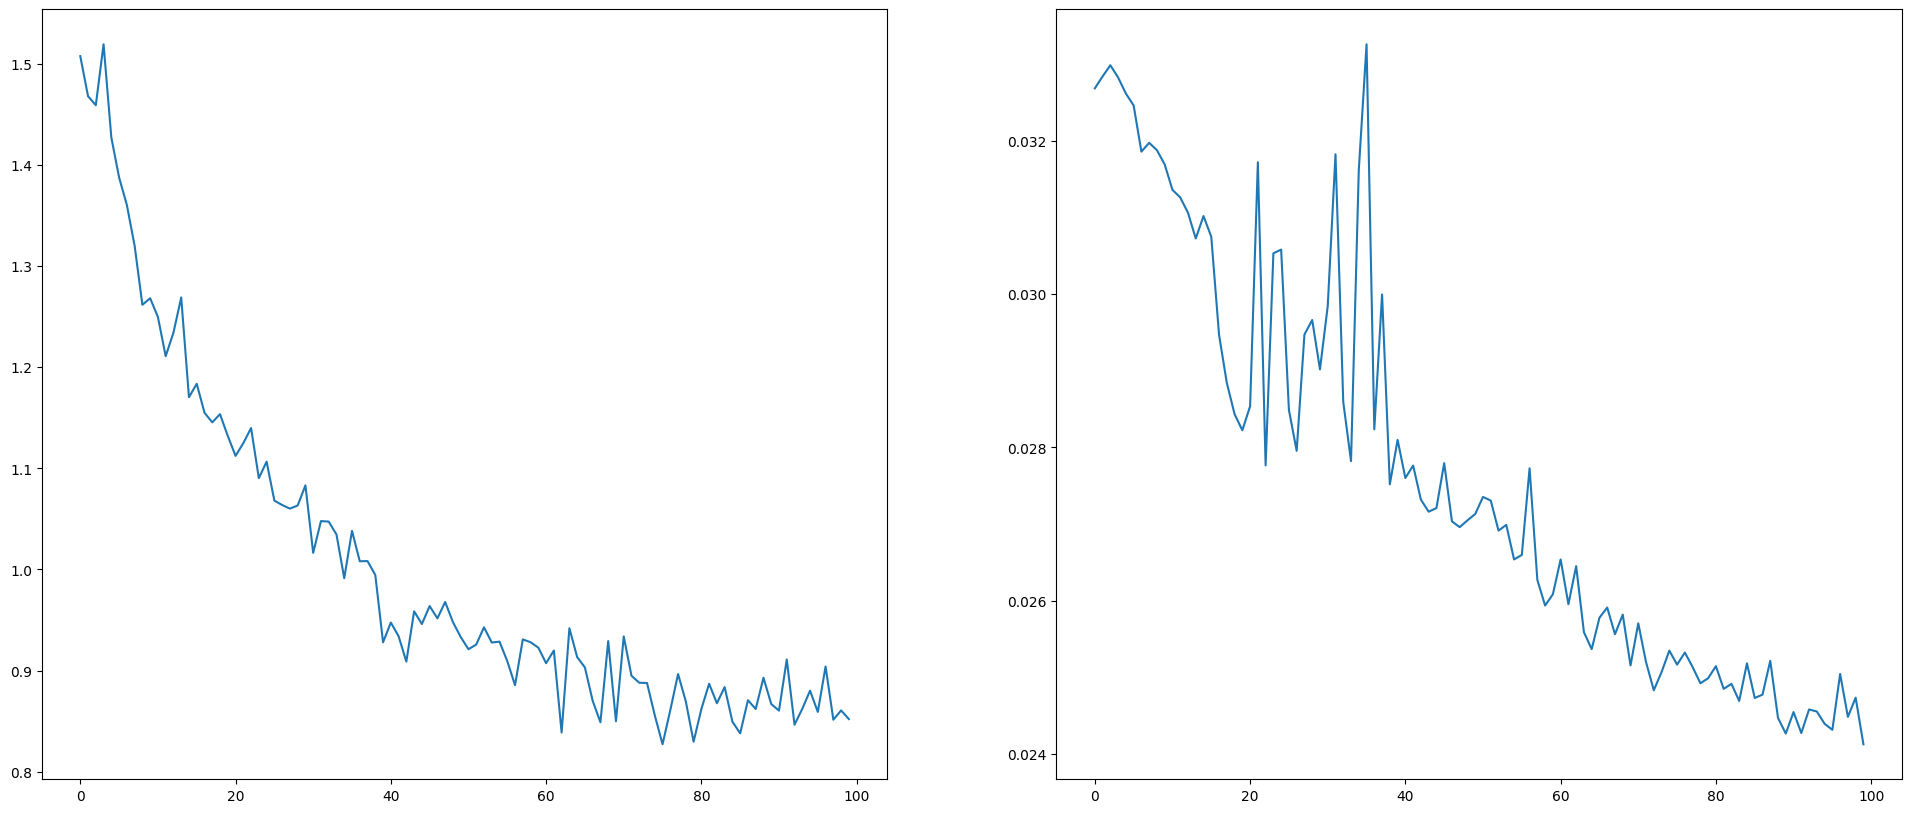

In [13]:
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.plot(loss_mat[:, 0, 0])

plt.subplot(1, 2, 2)
plt.plot(loss_mat[:, 0, 1])
plt.show()

In [15]:
real, preds = [], []
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        y_pred, _ = model.forward_pass(x)
        preds.extend(list(y_pred.cpu().detach().numpy()))
        real.extend(list(y.cpu().detach().numpy()))

auc = roc_auc_score(real, preds, average=None)

labels_true, labels_pred = np.argmax(real, axis=1), np.argmax(preds, axis=1)

# Compute F1
f1 = f1_score(labels_true, labels_pred, average=None)

# Compute Recall
rec = recall_score(labels_true, labels_pred, average=None)

# Compute NMI
nmi = normalized_mutual_info_score(labels_true, labels_pred)

print(f'AUCROC: \t{auc.mean():.5f}, \t{auc}')
print(f'F1-score: \t{f1.mean():.5f}, \t{f1}')
print(f'Recall: \t{rec.mean():.5f}, \t{rec}')
print(f'NMI: \t\t{nmi:.5f}')

AUCROC: 	0.76133, 	[0.90870631 0.78666427 0.71053614 0.63942949]
F1-score: 	0.13991, 	[0.         0.51212938 0.         0.04749613]
Recall: 	0.37705, 	[0.         0.72852761 0.         0.77966102]
NMI: 		0.10966


In [16]:
np.unique(np.argmax(test_dataset.y, axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  20,  652, 2350,   59], dtype=int64))

In [17]:
np.unique(np.argmax(preds, axis=1), return_counts=True)

(array([1, 3], dtype=int64), array([1203, 1878], dtype=int64))

In [18]:
np.unique(np.argmax(train_dataset.y, axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  18,  586, 2115,   53], dtype=int64))

In [19]:
np.unique(np.argmax(dataset.y, axis=1), return_counts=True)[1] / len(dataset)

array([0.00649266, 0.21153097, 0.76275808, 0.01921828])